## Predicting the 2019 NBA All-Stars

This notebook looks at predicting the 2019 NBA All-Stars, based on historical stats and All-Star selections. I'm not going to do a ton of Exploratory Data Analysis or feature engineering, because I'm pretty familiar with basketball stats in general, but I will provide some explanations along the way.

The end result will be a classification model that I'll use on the current season (2018-2019) stats dataset to predict the probability of All-Star selection.

In [15]:
#importing all the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics # for the check the error and accuracy of the model
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns #interactive plot
%matplotlib inline
warnings.filterwarnings(action='once')

C:\Users\Spelk\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
path = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\2019_All_Star_Model\new_player_data.xlsx'
df = pd.read_excel(path,sheet_name='dataframe')

Here is a preview of the data I'll be using. I have 32 columns, and over 1000 rows of player data. I pulled the stats from NBA.com and went back to the 2012-2013 season. I only pulled the top 150 scorers from each year (which contained every single All-Star). The reason I only pull the top 150 is because each season could have 500 players. If there are only 24 All-Stars, that's less than 5% of players. In other words, I could predict "No" every single time, and end up with an accuracy of 95%. 24/150 gives me a baseline of 84% accuracy (predicting "No" on all 150). If I can't build a model that has better than 84% accuracy, the model is not very useful.

In [3]:
df.head()

,Player ID,PLAYER,TEAM,AGE,GP,WIN_P,MIN,PTS,FGM,FGA,...,STL,BLK,PF,FP,DD2,TD3,+/-,Season,Eastern Conference,All Star IND
0,1,James Harden,HOU,28,50,0.800000,35.8,31.3,9.3,20.8,...,1.8,0.7,2.4,54.1,22,3,7.4,2017-2018,0,1
1,2,Giannis Antetokounmpo,MIL,23,53,0.566038,37.0,27.8,10.2,18.9,...,1.4,1.3,3.0,52.9,28,1,3.3,2017-2018,1,1
2,3,Anthony Davis,NOP,25,51,0.549020,36.4,27.4,10.0,18.6,...,1.3,2.1,2.0,52.2,32,0,2.6,2017-2018,0,1
3,4,Stephen Curry,GSW,30,43,0.767442,32.9,26.6,8.4,17.2,...,1.6,0.1,2.3,44.5,4,0,9.0,2017-2018,0,1
4,5,LeBron James,CLE,33,56,0.607143,37.0,26.5,10.2,18.7,...,1.5,1.0,1.6,52.9,32,10,-0.1,2017-2018,1,1


# Variable Selection
I have 32 columns, but I'm going ot cut this down. There are more sofisticated ways to do this, but I'll select variables/stats that make the most sense to me, and then male a correlation plot to see if I should eliminate any varables. Here are the ones I'm selecting initially.

In [17]:
collist = df.columns.tolist()
pred_vars = df[['WIN_P','MIN','PTS','FGA','FG_P','3PA','3P_P','FTA',
                'FT_P','REB','AST','TOV','STL','BLK','+/-','All Star IND']]

In [18]:
pred_vars.head()

,WIN_P,MIN,PTS,FGA,FG_P,3PA,3P_P,FTA,FT_P,REB,AST,TOV,STL,BLK,+/-,All Star IND
0,0.800000,35.8,31.3,20.8,44.8,10.7,38.4,9.9,86.5,5.1,9.0,4.2,1.8,0.7,7.4,1
1,0.566038,37.0,27.8,18.9,54.0,1.8,29.0,9.1,75.3,10.4,4.8,2.8,1.4,1.3,3.3,1
2,0.549020,36.4,27.4,18.6,54.1,2.1,36.7,7.9,82.0,10.7,2.4,2.1,1.3,2.1,2.6,1
3,0.767442,32.9,26.6,17.2,49.0,10.0,41.3,6.0,91.5,5.2,6.5,3.1,1.6,0.1,9.0,1
4,0.607143,37.0,26.5,18.7,54.4,4.8,36.2,6.1,73.7,8.1,8.9,4.4,1.5,1.0,-0.1,1


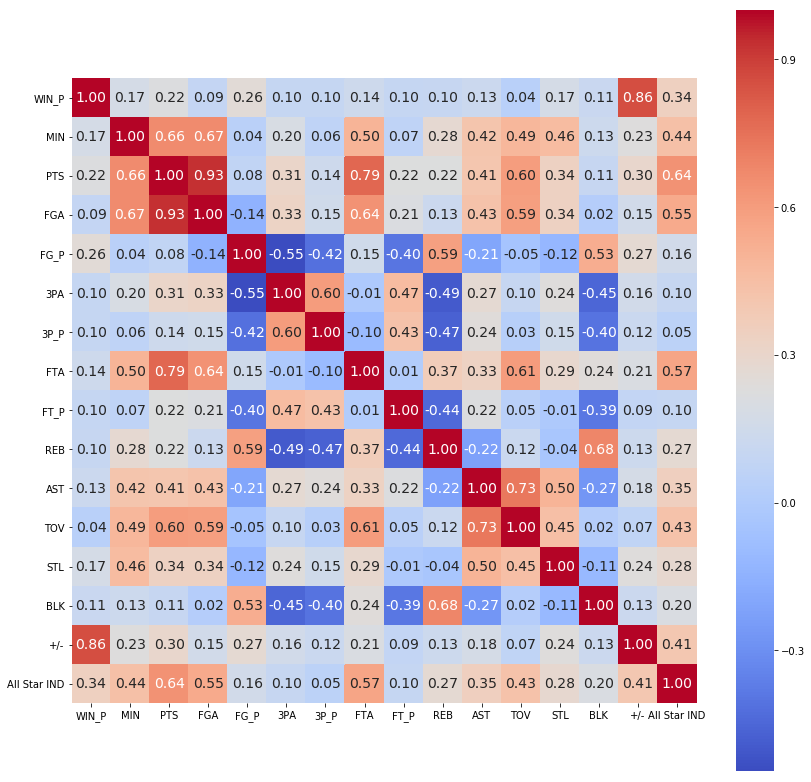

In [19]:
corr = pred_vars.corr()
plt.figure(figsize = (14,14))
sns.heatmap(corr,cbar= True, square = True, annot = True, fmt = '.2f', annot_kws = {'size':14},
            xticklabels = list(pred_vars.columns), yticklabels = list(pred_vars.columns), cmap = 'coolwarm')

The correlation plot above shows a correlation matrix between all 2-variable combinations. In the bottom row, we can see which variables correlate the most with "All Star IND." By no surpise, "Points" is what has the highest correlation (0.64). The one thing I notice in this is that "Points" and "FGA" have a .93 correlation. There's a concept called colinearity, which means that including both of these variables in the analysis could inflate the variance of the coefficient of one of the variables. Given that, I'll just keep points and delete FGA.

In [21]:
try:
    pred_vars.drop(axis = 1, labels = 'FGA',inplace=True)
except:
    pass

The next component will be to split the dataset into a training set and a test set or validation set. This is done in most modeling so we don't overfit the model to the data. Basically, new data might not completely resemble the old data, so we use a holdout dataset to test our model on, before actually testing it on this year's data.

In [22]:
#Split data into train and test sets
train, test = train_test_split(pred_vars, test_size = 0.3)
print(train.shape)
print(test.shape)

(735, 15)
(316, 15)


In [23]:
train_X = train.drop(axis = 1, labels = 'All Star IND')
test_X = test.drop(axis = 1, labels = 'All Star IND')
train_Y = train[['All Star IND']]
test_Y = test[['All Star IND']]

## Building the Classification Model
Now the fun part, building the classification model. I'm going to use the xgboost classifier.

In [26]:
shap.initjs()

C:\Users\Spelk\Anaconda3\lib\site-packages\shap\plots\force.py:155: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\Spelk\\Anaconda3\\lib\\site-packages\\shap\\plots\\resources\\bundle.js' mode='r' encoding='utf-8'>
  bundle_data = io.open(bundle_path, encoding="utf-8").read()
C:\Users\Spelk\Anaconda3\lib\site-packages\shap\plots\force.py:157: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\Spelk\\Anaconda3\\lib\\site-packages\\shap\\plots\\resources\\logoSmallGray.png'>
  logo_data = base64.b64encode(open(logo_path, "rb").read()).decode('utf-8')


In [33]:
model2 = xgb.XGBClassifier(max_depth=15, n_estimators=300, learning_rate=0.01, objective = 'binary:logistic')
model2.fit(train_X,train_Y)

preds_proba = model2.predict_proba(test_X)
preds = model2.predict(test_X)

C:\Users\Spelk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Spelk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [34]:
results = test_Y == list(preds)
results.groupby('All Star IND',as_index = True)['All Star IND'].count()

All Star IND
False     21
True     295
Name: All Star IND, dtype: int64

***Accuracy***

In [39]:
print("Percent Accuracy:",round(295/(316),3))

Percent Accuracy: 0.934


My model had an accuracy of 93.4% on the test set (295/316). This is pretty good, and I can dive into which predictions the model got wrong. Some of them could be injury related, but I can explore that later.

Here is a graph that shows the importance/impact of each variable on the model output. This is a function from the SHAP package. In simple terms, SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP values represent a feature's responsibility for a change in the model output.

The plot below shows the SHAP magnitude across all examples in the traning data. The color represents the variable value (red high, blue low). For example, high PTS pushes the model output (probability) higher. And low PTS pushes the output lower.

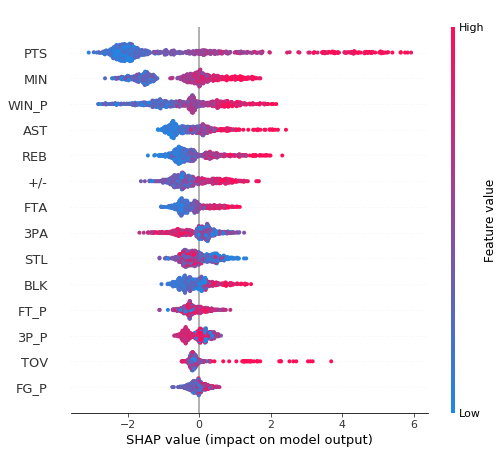

In [41]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_X)

We can actually take a look at an individual observation this way as well, which will be a little more intuitive. Here is the observation for the player with the highest points/gm total, but wasn't selected. In this case (as seen below) it's Damian Lillard in 2016-2017.

In [60]:
train_shap = train_X.merge(df,how='left', left_index=True, right_index=True)
train_shap = train_shap[['PLAYER','TEAM','Season','PTS_x','All Star IND']]
sorted_shap = train_shap.sort_values(by = ['PTS_x'], ascending=False)
sorted_shap.head(25)

,PLAYER,TEAM,Season,PTS_x,All Star IND
601,Kevin Durant,OKC,2013-2014,31.5,1
0,James Harden,HOU,2017-2018,31.3,1
152,Isaiah Thomas,BOS,2016-2017,29.9,1
751,Kevin Durant,OKC,2012-2013,29.2,1
153,James Harden,HOU,2016-2017,29.2,1
901,Kobe Bryant,LAL,2011-2012,28.4,1
154,DeMarcus Cousins,NOP,2016-2017,27.8,1
303,Kevin Durant,OKC,2015-2016,27.7,1
155,Anthony Davis,NOP,2016-2017,27.7,1
2,Anthony Davis,NOP,2017-2018,27.4,1


In [72]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(train_X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[160,:], train_X.loc[160,:])

Based on the plot above, my model would've correctly predicted that DLillard would not makes the All-Star game. All of the blue bars are variables that pushed his model output down - you can see that his 25.7 ppg is the only thing that was pushing the model output higher.

I'll now add the predictions to my test set to see which predictions were wrong.

In [76]:
test['Prediction']=preds
test_preds = test.merge(df,how='left', left_index=True, right_index=True)

C:\Users\Spelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
test_preds = test_preds[['PLAYER','TEAM','Season','All Star IND_y','Prediction']]
test_preds.head(25)

,PLAYER,TEAM,Season,All Star IND_y,Prediction
753,LeBron James,MIA,2012-2013,1,1
159,Kevin Durant,GSW,2016-2017,1,1
122,Marcus Morris,BOS,2017-2018,0,0
266,Josh Richardson,MIA,2016-2017,0,0
1,Giannis Antetokounmpo,MIL,2017-2018,1,1
167,Giannis Antetokounmpo,MIL,2016-2017,1,1
489,Ty Lawson,DEN,2014-2015,0,0
583,Tyson Chandler,DAL,2014-2015,0,1
846,JJ Hickson,POR,2012-2013,0,0
610,DeMar DeRozan,TOR,2013-2014,1,1


In [78]:
This_Year = pd.read_excel(path,sheet_name='This_Season')
pred_vars2 = This_Year[['WIN_P','MIN','PTS','FG_P','3PA','3P_P','FTA',
                'FT_P','REB','AST','TOV','STL','BLK','+/-']]


The last step in this notebook will be to predict this year's All-Stars with my model. After that, I'll use Tableau to vizualize who should be playing in Atlanta this year, and who got in based on popularity.

In [79]:
preds_proba2 = model2.predict_proba(pred_vars2)
df_prob = []
for i in preds_proba2:
    df_prob.append(i[1])
This_Year['Pred_Prob'] = df_prob
This_Year.head(20)

,Player ID,PLAYER,TEAM,AGE,GP,WIN_P,MIN,PTS,FGM,FGA,...,STL,BLK,PF,FP,DD2,TD3,+/-,Season,Eastern Conference,Pred_Prob
0,1,James Harden,HOU,29,38,0.605263,37.1,34.1,9.9,22.6,...,2.0,0.6,3.4,56.7,16,6,2.3,2018-2019,0,0.955899
1,2,Anthony Davis,NOP,25,38,0.500000,36.9,28.9,10.4,20.2,...,1.7,2.6,2.6,62.5,30,0,4.6,2018-2019,0,0.943047
2,3,Stephen Curry,GSW,30,31,0.741935,34.5,28.8,9.6,19.8,...,1.3,0.3,2.5,45.1,1,0,9.5,2018-2019,0,0.950117
3,4,Kevin Durant,GSW,30,42,0.666667,35.6,28.2,9.7,19.2,...,0.8,1.0,1.9,48.3,12,2,7.8,2018-2019,0,0.948149
4,5,Kawhi Leonard,TOR,27,35,0.714286,34.9,27.5,9.6,19.1,...,1.9,0.5,1.6,47.1,11,0,5.4,2018-2019,1,0.961312
5,6,LeBron James,LAL,34,34,0.588235,34.7,27.3,10.0,19.3,...,1.3,0.7,1.6,50.6,17,3,2.8,2018-2019,0,0.936050
6,7,Joel Embiid,PHI,24,41,0.658537,33.7,26.9,8.9,18.3,...,0.6,2.0,3.3,52.2,36,1,4.4,2018-2019,1,0.827697
7,8,Paul George,OKC,28,41,0.609756,35.7,26.7,9.1,20.5,...,2.2,0.5,2.8,47.7,14,0,7.1,2018-2019,0,0.963338
8,9,Giannis Antetokounmpo,MIL,24,38,0.710526,33.6,26.6,9.9,17.1,...,1.3,1.5,3.4,55.3,28,3,7.9,2018-2019,1,0.873950
9,10,Damian Lillard,POR,28,43,0.604651,35.2,25.8,8.5,19.0,...,1.0,0.5,1.8,42.3,5,0,3.7,2018-2019,0,0.915957


In [86]:
This_Year[['PLAYER','TEAM','Season','Pred_Prob']]

,PLAYER,TEAM,Season,Pred_Prob
0,James Harden,HOU,2018-2019,0.955899
1,Anthony Davis,NOP,2018-2019,0.943047
2,Stephen Curry,GSW,2018-2019,0.950117
3,Kevin Durant,GSW,2018-2019,0.948149
4,Kawhi Leonard,TOR,2018-2019,0.961312
5,LeBron James,LAL,2018-2019,0.936050
6,Joel Embiid,PHI,2018-2019,0.827697
7,Paul George,OKC,2018-2019,0.963338
8,Giannis Antetokounmpo,MIL,2018-2019,0.873950
9,Damian Lillard,POR,2018-2019,0.915957
